In [1]:
# Basic imports
import sys

# System path modification
sys.path.insert(0, '..')

import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn.image import new_img_like

from nilearn import plotting
import numpy as np
import seaborn as sns

from src.dataset import *

## Load data 

In [2]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [3]:
data.keys()

dict_keys(['df_X', 'df_y', 'df_all', 'df_FinalCombination', 'dict_select', 'df_select_features', 'colormaps'])

# Import data and convert to Brain altas mapping

In [4]:
select_MRIthickness = [x.replace("_Cortical", "") for x in select_MRIthickness]

In [5]:
local_matrix = pd.read_csv('../pickle/TabNet_local_MRI.csv', names=["Importance"], header=None)
local_matrix.index = select_MRIthickness

In [6]:
mmse_template = pd.read_csv('../figures/adni_feature_importances_MMSE.csv')
mmse_template.set_index("feature", inplace=True)

In [7]:
local_matrix = local_matrix.reindex(index=mmse_template.index)

In [8]:
atlas_path = '../figures/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'  # Path to the atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load region label map from data/AD/Schaefer2018_200Parcels_7Networks_order_info.txt, each line is feature_name,region_label
region_label_map = pd.read_csv('../figures/Schaefer2018_200Parcels_7Networks_order_info.txt')
region_label_map = region_label_map.set_index('feature_name')['region_label']

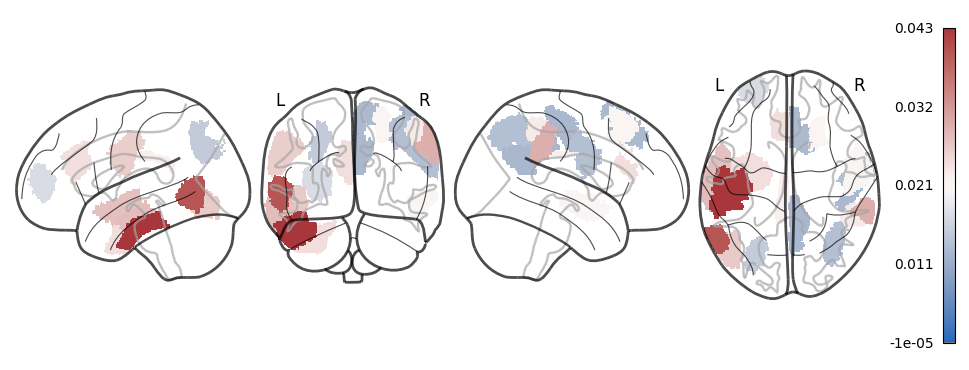

In [9]:
df = local_matrix.reset_index(names="feature").rename(columns={"Importance":"importance"})

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['abs_importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap="vlag",
    display_mode='lyrz',
)

plt.savefig(f'../figures/adni_brain_tabnet_local.png')
# Show the plot
plotting.show()

# Perturbation method feature importance

In [10]:
def plot_top_brain_importances(
    perturbation_matrix: pd.DataFrame,
    metric_name: str,
    select_features: list,
    atlas_data: np.ndarray,
    atlas_img,
    region_label_map: dict,
    output_dir: str,
    vmax: float = None,
    n_top: int = 20,
    cmap: str = "vlag"
):
    """
    Plot brain importance maps from a permutation importance matrix using a brain atlas.

    Args:
    - permutation_matrix (pd.DataFrame): DataFrame with shape [n_features, n_targets].
    - select_features (list): Ordered list of features matching brain atlas regions (used as index).
    - atlas_data (np.ndarray): 3D atlas data with integer labels for each brain region.
    - atlas_img (nib.Nifti1Image): NIfTI image of the atlas, used for creating new images.
    - region_label_map (dict): Maps feature names to atlas integer region labels.
    - metric_name (str) : Name under which to save the plot files.  
    - output_dir (str): Directory to save plots.
    - vmax (float, optional): Max value for color scale. If None, computed from the matrix.
    - n_top (int): Number of top features to display.
    - cmap (str): Colormap for brain plot.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Ensure correct indexing
    perturbation_matrix = perturbation_matrix.copy()
    perturbation_matrix.index = select_features

    # Reorder to match template
    perturbation_matrix = perturbation_matrix.reindex(index=select_features)

    # Determine vmax if not provided
    if vmax is None:
        vmax = round(perturbation_matrix.abs().max().max(), 2)

    for target in perturbation_matrix.columns:
        df = perturbation_matrix[target].reset_index().rename(columns={
            'index': 'feature',
            target: 'importance'
        })

        df['abs_importance'] = df['importance'].abs()
        df_sorted = df.sort_values(by='abs_importance', ascending=False).head(n_top)

        importance_map = np.zeros_like(atlas_data, dtype=np.float32)

        for _, row in df_sorted.iterrows():
            feature = row['feature']
            importance = row['abs_importance']
            region_idx = region_label_map.get(feature, None)

            if region_idx is not None:
                importance_map[atlas_data == region_idx] = importance

        importance_img = new_img_like(atlas_img, importance_map)

        # Plot and save
        fig = plotting.plot_glass_brain(
            importance_img,
            colorbar=True,
            cmap=cmap,
            display_mode='lyrz',
            vmin=0,
            vmax=vmax,
            title=f"{target} - Top {n_top} Regions"
        )

        fig.savefig(os.path.join(output_dir, f"brain_tabnet_{metric_name}_{target.lower().replace(' ', '_')}.png"))
        plt.close()

# Feature Importance on Test

### Permutation importance (Pearson scorer)

In [11]:
# Load permutation matrix
matrix = pd.read_csv(
    '../pickle/TabNet_shap_train_MRI.csv',
    names=["Memory", "Executive Function", "Visuospatial", "Language"],
    header=None
)

# Set index and match template
matrix.index = select_MRIthickness

# Plot
plot_top_brain_importances(
    perturbation_matrix=matrix,
    select_features=mmse_template.index.tolist(),  # assuming same order
    atlas_data=atlas_data,
    atlas_img=atlas_img,
    region_label_map=region_label_map,
    metric_name="shap",
    output_dir="../figures/brain_tabnet_perm/",
    vmax=None,  # optional
    n_top=20,
    cmap="magma_r"
)

#### Permutation importance (MAE scorer)

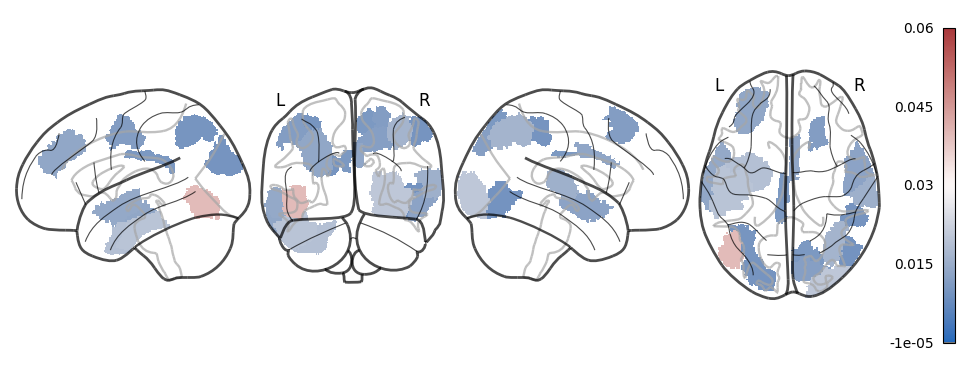

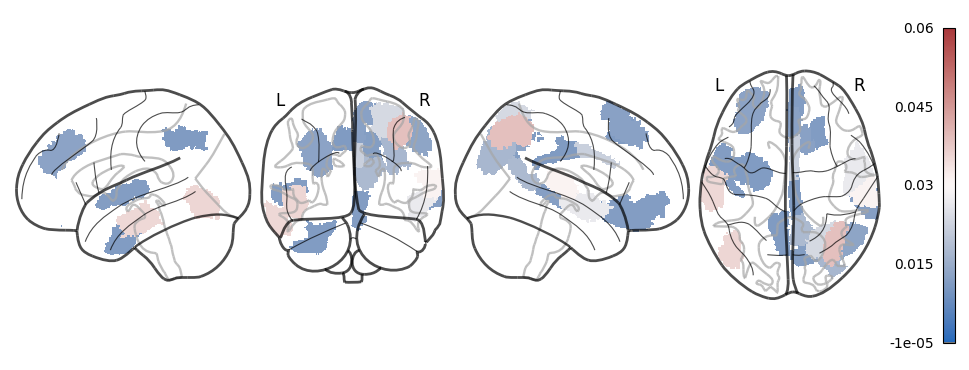

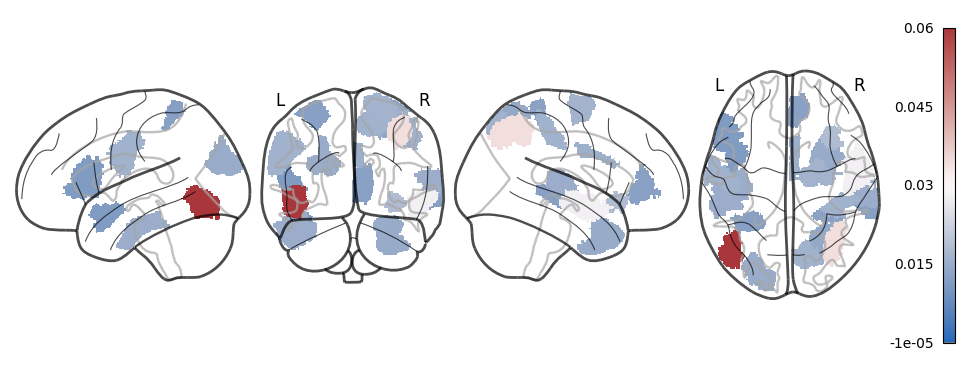

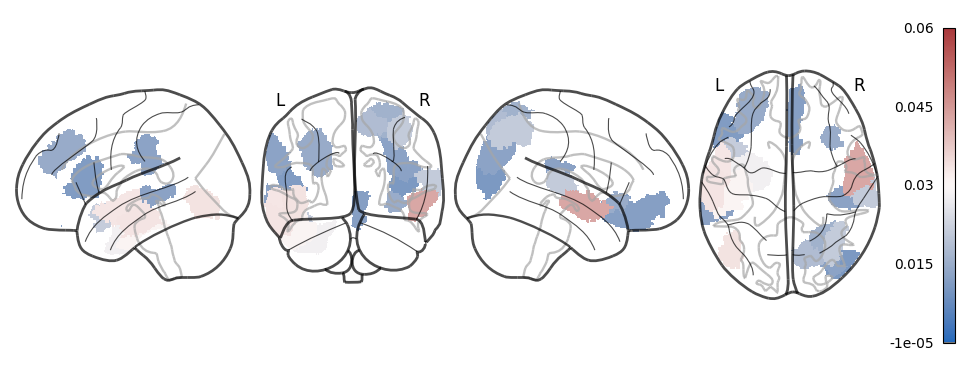

In [12]:
perm_mae_matrix= pd.read_csv('../pickle/TabNet_permutation_mae_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_mae_matrix.index = select_MRIthickness
perm_mae_matrix = perm_mae_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_mae_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region[
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_mae_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Shapley importance

In [13]:
shap_matrix= pd.read_csv('../pickle/TabNet_shap_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_matrix.index = select_MRIthickness
shap_matrix = shap_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0, 
        vmax=round(shap_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_{target.lower()}.png')
    # Show the plot
    plotting.show()

FileNotFoundError: [Errno 2] No such file or directory: '../pickle/TabNet_shap_MRI.csv'

# Feature importances values on Train

#### Shapley importance

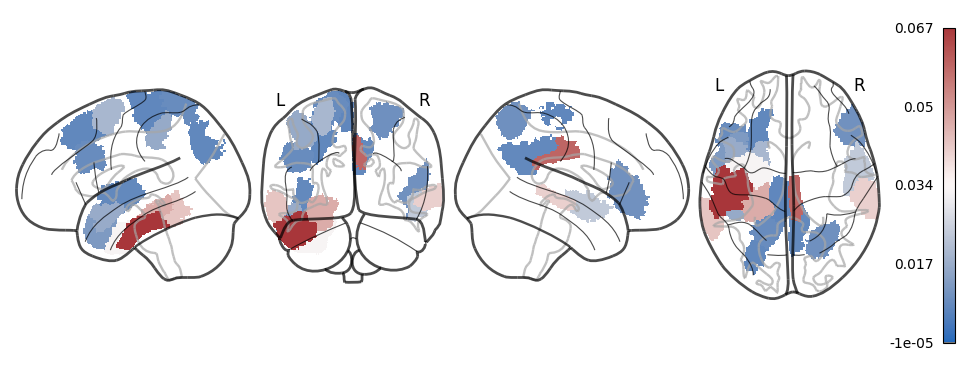

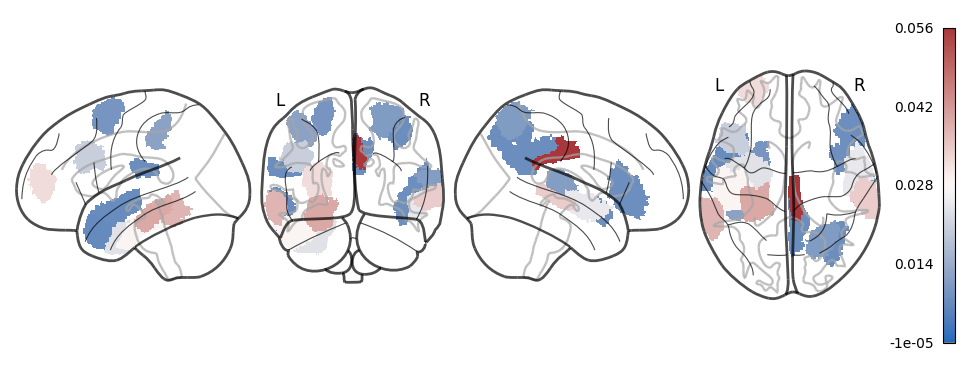

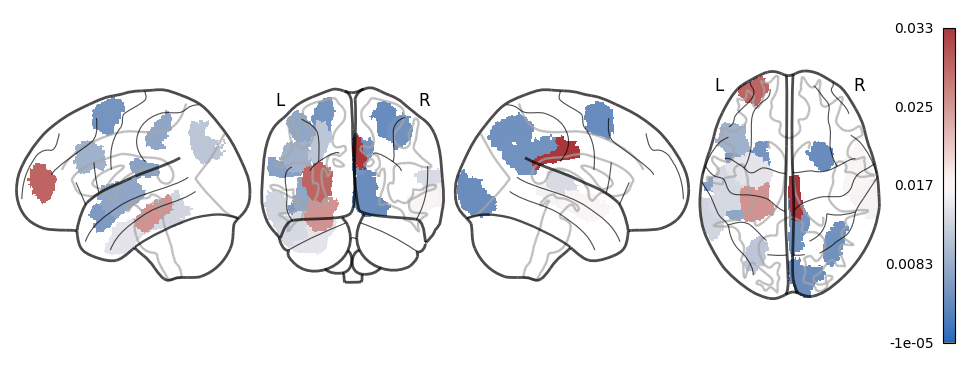

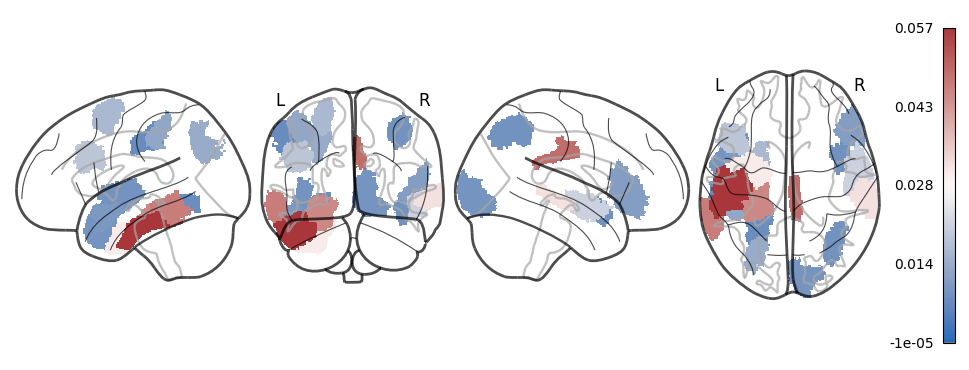

In [ ]:
shap_train_matrix= pd.read_csv('../pickle/TabNet_shap_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_train_matrix.index = select_MRIthickness
shap_train_matrix = shap_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0, 
        #vmax=round(shap_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (Pearson scorer)

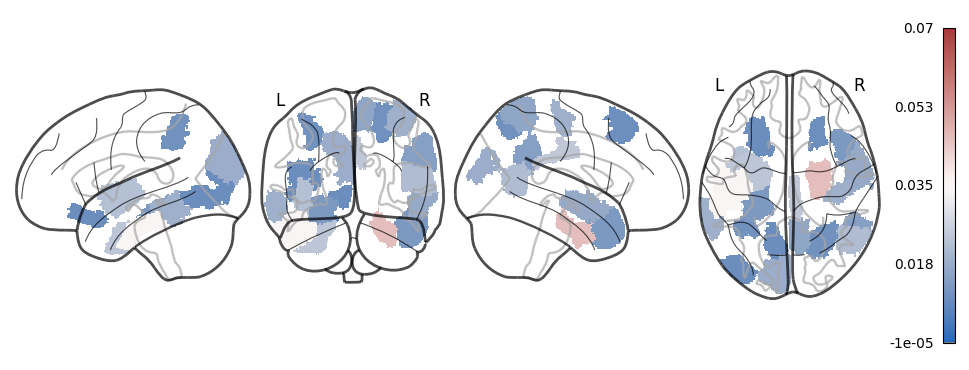

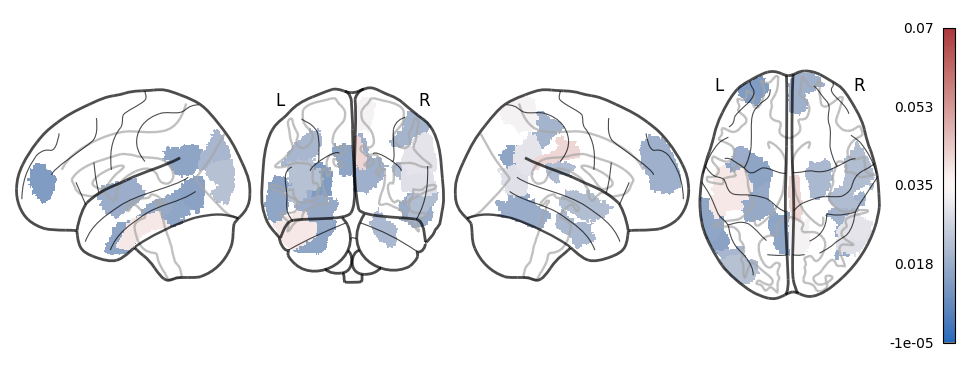

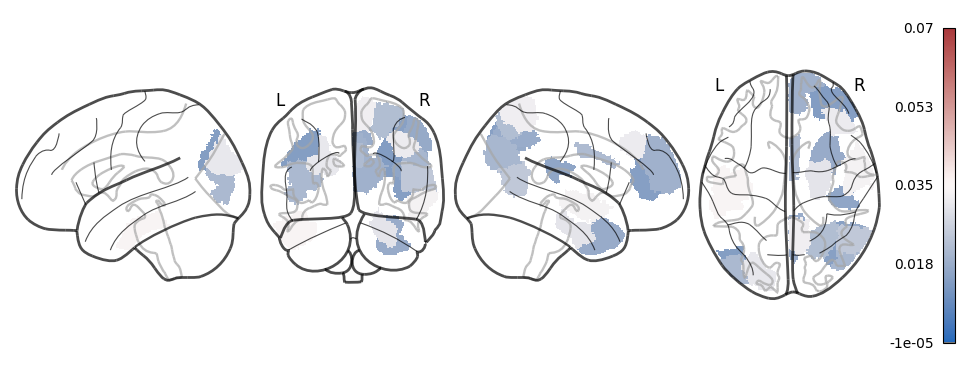

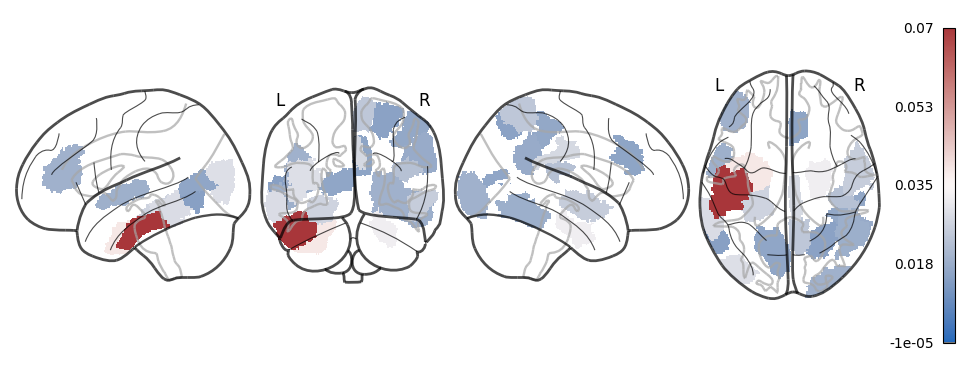

In [ ]:
perm_train_matrix= pd.read_csv('../pickle/TabNet_permutation_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select_MRIthickness
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (MAE scorer)

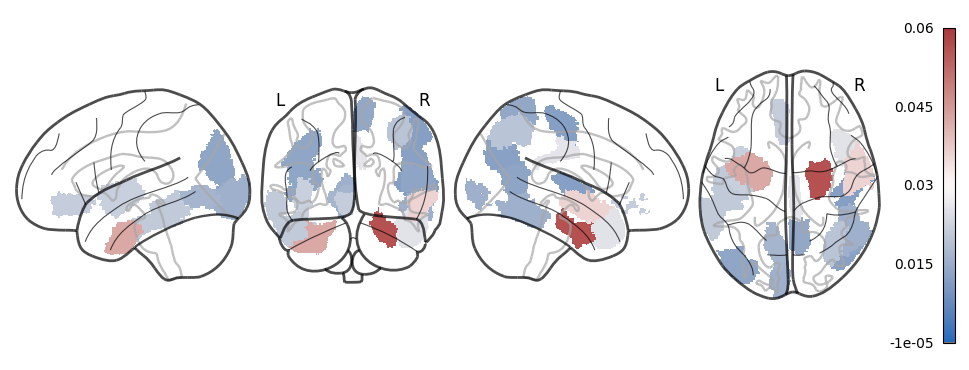

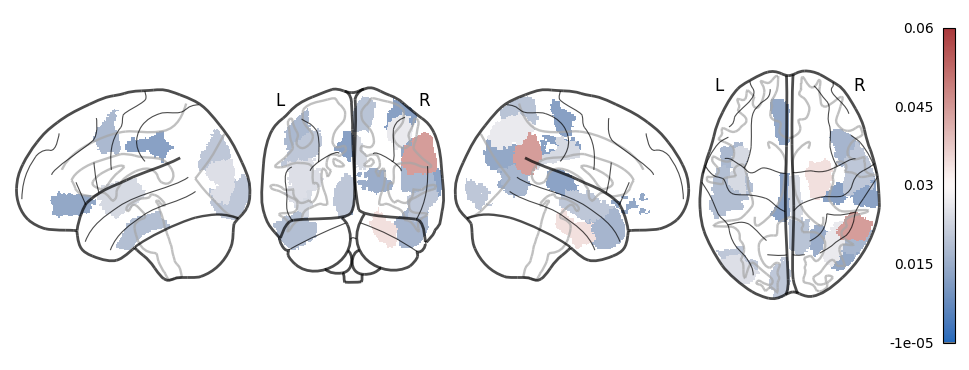

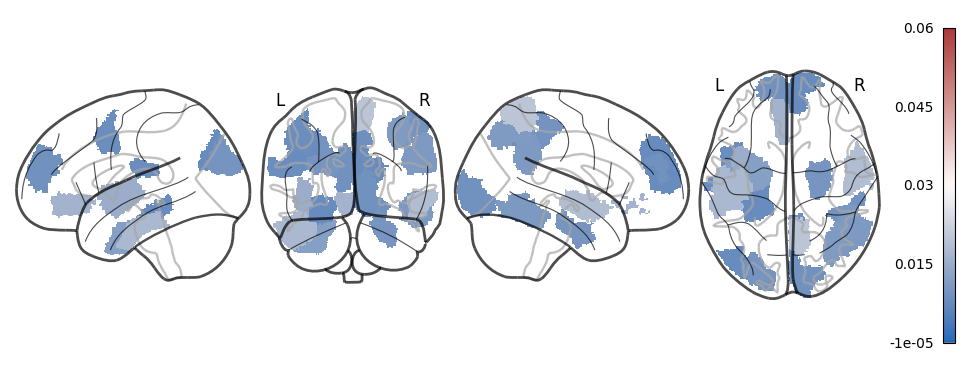

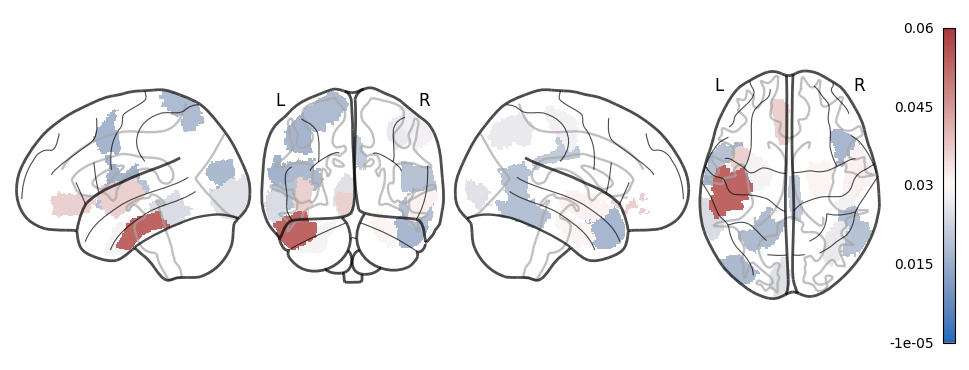

In [ ]:
perm_train_matrix= pd.read_csv('../pickle/TabNet_permutation_mae_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select_MRIthickness
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Owen values

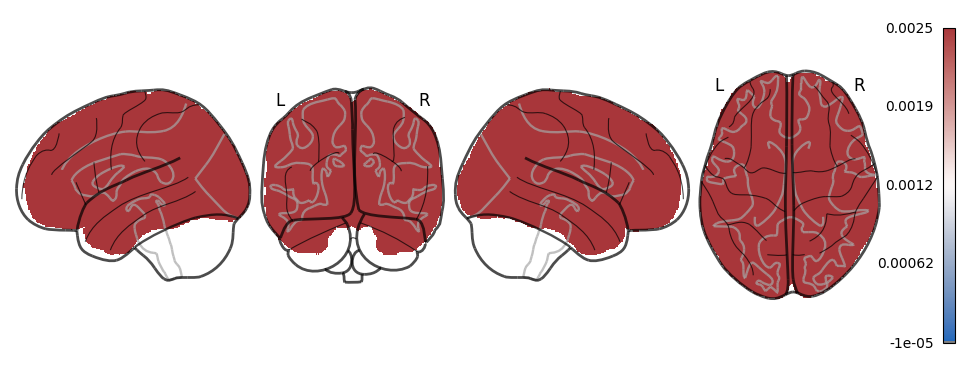

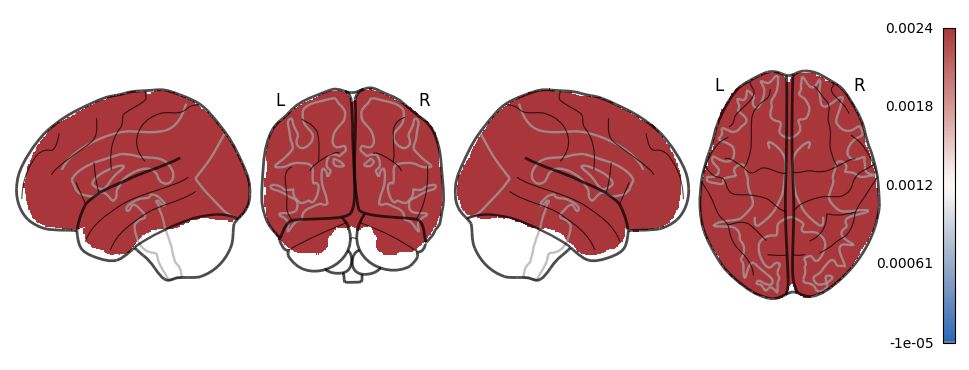

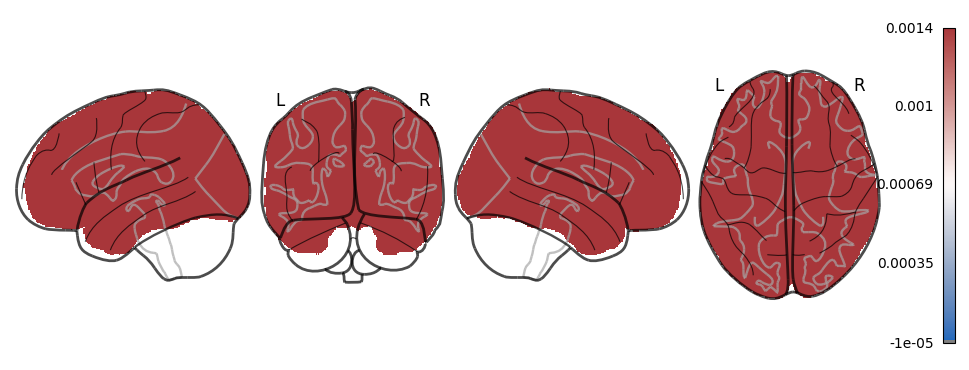

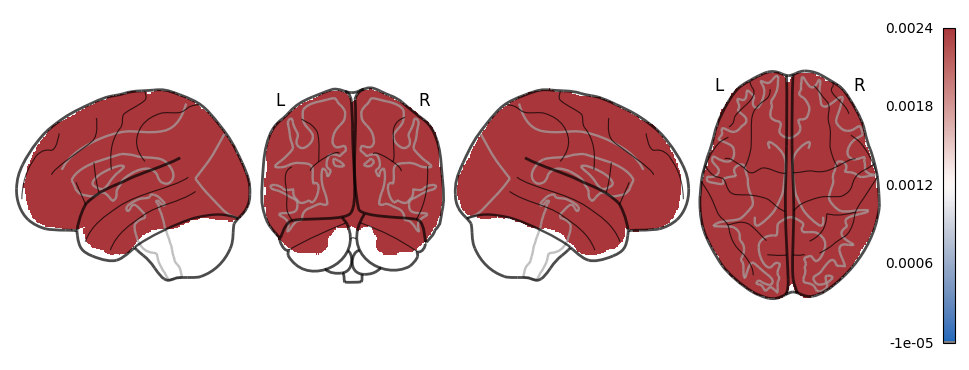

In [ ]:
owen_matrix= pd.read_csv('../pickle/TabNet_owen_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
owen_matrix.index = select_MRIthickness
owen_matrix = owen_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  owen_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
    )

    plt.savefig(f'../figures/adni_brain_tabnet_owen_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Captum

In [14]:
def extract_model_metric_target(filename):
    # Remove file extension
    parts = filename.replace('.csv', '').split('_')
    model = parts[0]
    metric = parts[1]
    return model, metric

In [ ]:
for brainfile in os.listdir("../figures/captum/brain_maps"): 
    if ".csv" in brainfile: 

        print(f"Processing : {brainfile}")
        model, metric = extract_model_metric_target(brainfile)

        # Load permutation matrix
        matrix = pd.read_csv(
            f"../figures/captum/brain_maps/{brainfile}",
            names=["Memory", "Executive Function", "Visuospatial", "Language"],
            header=None
        )

        # Set index and match templae
        matrix.index = select_MRIthickness

        # Plot
        plot_top_brain_importances(
            perturbation_matrix=matrix,
            select_features=mmse_template.index.tolist(),  # assuming same order
            atlas_data=atlas_data,
            atlas_img=atlas_img,
            region_label_map=region_label_map,
            metric_name=metric,
            output_dir="../figures/captum/brain_maps",
            vmax=None,  # optional
            n_top=30,
            cmap="magma_r"
        )

Processing : tabnet_kernelshap_to_brain.csv
Processing : tabnet_permutation_to_brain.csv
Processing : tabnet_lime_to_brain.csv
Processing : tabnet_ablation_to_brain.csv
Processing : tabnet_occlusion_to_brain.csv
Processing : tabnet_shapley_to_brain.csv


In [16]:
brainfile = "tabnet_shapley_to_brain.csv"

In [17]:
# Load permutation matrix
matrix = pd.read_csv(
    f"../figures/captum/brain_maps/{brainfile}",
    names=["Memory", "Executive Function", "Visuospatial", "Language"],
    header=None
)

# Set index and match templae
matrix.index = select_MRIthickness

# Debug

In [18]:
matrix.index.tolist()

['LH_Vis_1',
 'RH_Vis_1',
 'LH_Vis_2',
 'RH_Vis_2',
 'LH_Vis_3',
 'RH_Vis_3',
 'LH_Vis_4',
 'RH_Vis_4',
 'LH_Vis_5',
 'RH_Vis_5',
 'LH_Vis_6',
 'RH_Vis_6',
 'LH_Vis_7',
 'RH_Vis_7',
 'LH_Vis_8',
 'RH_Vis_8',
 'LH_Vis_9',
 'RH_Vis_9',
 'LH_Vis_10',
 'RH_Vis_10',
 'LH_Vis_11',
 'RH_Vis_11',
 'LH_Vis_12',
 'RH_Vis_12',
 'LH_Vis_13',
 'RH_Vis_13',
 'LH_Vis_14',
 'RH_Vis_14',
 'LH_SomMot_1',
 'RH_Vis_15',
 'LH_SomMot_2',
 'RH_SomMot_1',
 'LH_SomMot_3',
 'RH_SomMot_2',
 'LH_SomMot_4',
 'RH_SomMot_3',
 'LH_SomMot_5',
 'RH_SomMot_4',
 'LH_SomMot_6',
 'RH_SomMot_5',
 'LH_SomMot_7',
 'RH_SomMot_6',
 'LH_SomMot_8',
 'RH_SomMot_7',
 'LH_SomMot_9',
 'RH_SomMot_8',
 'LH_SomMot_10',
 'RH_SomMot_9',
 'LH_SomMot_11',
 'RH_SomMot_10',
 'LH_SomMot_12',
 'RH_SomMot_11',
 'LH_SomMot_13',
 'RH_SomMot_12',
 'LH_SomMot_14',
 'RH_SomMot_13',
 'LH_SomMot_15',
 'RH_SomMot_14',
 'LH_SomMot_16',
 'RH_SomMot_15',
 'LH_DorsAttn_Post_1',
 'RH_SomMot_16',
 'LH_DorsAttn_Post_2',
 'RH_SomMot_17',
 'LH_DorsAttn_Post_3',


In [19]:
from nilearn import datasets

# Fetch Schaefer 2018 atlas with 200 parcels and 7 networks
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=1)

# The atlas labels are stored in schaefer['labels']
labels = schaefer['labels']

# Print all labels
for i, label in enumerate(labels):
    print(f"{i}: {label}")


[get_dataset_dir] Dataset found in /home/cschneuwly/nilearn_data/schaefer_2018

0: b'7Networks_LH_Vis_1'
1: b'7Networks_LH_Vis_2'
2: b'7Networks_LH_Vis_3'
3: b'7Networks_LH_Vis_4'
4: b'7Networks_LH_Vis_5'
5: b'7Networks_LH_Vis_6'
6: b'7Networks_LH_Vis_7'
7: b'7Networks_LH_Vis_8'
8: b'7Networks_LH_Vis_9'
9: b'7Networks_LH_Vis_10'
10: b'7Networks_LH_Vis_11'
11: b'7Networks_LH_Vis_12'
12: b'7Networks_LH_Vis_13'
13: b'7Networks_LH_Vis_14'
14: b'7Networks_LH_SomMot_1'
15: b'7Networks_LH_SomMot_2'
16: b'7Networks_LH_SomMot_3'
17: b'7Networks_LH_SomMot_4'
18: b'7Networks_LH_SomMot_5'
19: b'7Networks_LH_SomMot_6'
20: b'7Networks_LH_SomMot_7'
21: b'7Networks_LH_SomMot_8'
22: b'7Networks_LH_SomMot_9'
23: b'7Networks_LH_SomMot_10'
24: b'7Networks_LH_SomMot_11'
25: b'7Networks_LH_SomMot_12'
26: b'7Networks_LH_SomMot_13'
27: b'7Networks_LH_SomMot_14'
28: b'7Networks_LH_SomMot_15'
29: b'7Networks_LH_SomMot_16'
30: b'7Networks_LH_DorsAttn_Post_1'
31: b'7Networks_LH_DorsAttn_Post_2'
32: b'7Networks_LH_DorsAttn_Post_3'
33: b'7Networks_LH_DorsAttn_Post_4'
34: b'7Networks_LH_DorsAtt

In [20]:
df_X.iloc[1, -200:]

LH_Vis_1_Cortical                2.201539
RH_Vis_1_Cortical                2.708529
LH_Vis_2_Cortical                2.041111
RH_Vis_2_Cortical                2.384180
LH_Vis_3_Cortical                2.191083
                                   ...   
RH_Default_pCunPCC_1_Cortical    2.394510
LH_Default_pCunPCC_4_Cortical    2.171651
RH_Default_pCunPCC_2_Cortical    2.356982
LH_Default_PHC_1_Cortical        2.350920
RH_Default_pCunPCC_3_Cortical    2.289715
Name: 4, Length: 200, dtype: float64

In [21]:
matrix_X = df_X.iloc[1:3, -200:].T

In [22]:
matrix = pd.DataFrame(np.zeros_like(matrix_X), index=matrix_X.index, columns=matrix_X.columns)

In [23]:
matrix.loc["LH_Default_PHC_1_Cortical"] = [1., 1. ]

AttributeError: 'int' object has no attribute 'lower'

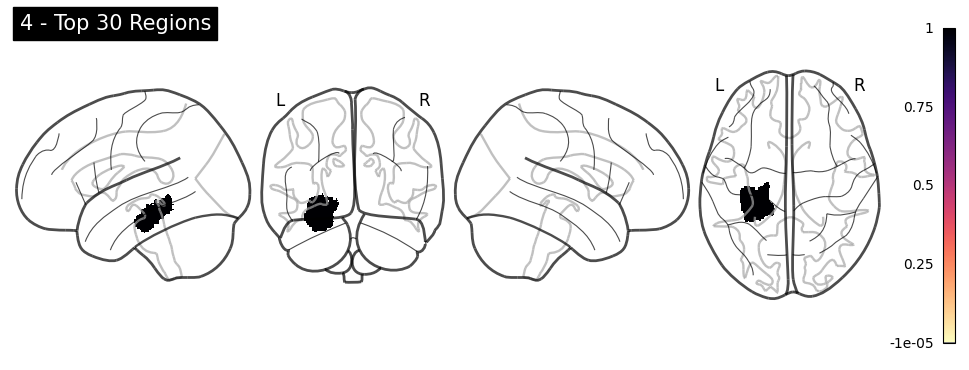

In [24]:
# Plot
plot_top_brain_importances(
    perturbation_matrix=matrix,
    select_features=mmse_template.index.tolist(),  # assuming same order
    atlas_data=atlas_data,
    atlas_img=atlas_img,
    region_label_map=region_label_map,
    metric_name=metric,
    output_dir="test",
    vmax=None,  # optional
    n_top=30,
    cmap="magma_r"
)